* convolutional neural network on MNIST by Chainer

In [2]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import model_selection, metrics
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [4]:
import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    from six.moves import urllib
    from scipy.io import loadmat
    import os
    print('Could not download MNIST data from mldata.org, trying alternative...')
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    mnist_path = './mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw['data'].T,
        "target": mnist_raw['label'][0],
        "COL_NAMES": ['label', 'data'],
        "DESCR": 'mldata.org dataset: mnist-original',
    }
    print('Success!')

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [5]:
mnist['data'] = mnist['data'].astype(np.float32).reshape(len(mnist['data']), 1, 28, 28) # image data
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32) # label data
mnist['data'].shape, mnist['target'].shape

((70000, 1, 28, 28), (70000,))

In [6]:
# train data size : validation data size= 8 : 2
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(mnist['data'], mnist['target'], test_size=0.2)

train_dataset = chainer.datasets.tuple_dataset.TupleDataset(train_x, train_y)
valid_dataset = chainer.datasets.tuple_dataset.TupleDataset(valid_x, valid_y)

len(train_dataset), len(valid_dataset)

(56000, 14000)

In [7]:
class CNN(chainer.Chain):
    
    def __init__(self):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 20, ksize=5),
            conv2 = L.Convolution2D(20, 50, ksize=5),
            fc1 = L.Linear(None, 500),
            fc2 = L.Linear(500, 500),
            fc3 = L.Linear(500, 10)
        )
    
    def __call__(self, x):
        
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = self.fc1(h)
        h = self.fc2(h)
        y = self.fc3(h)
        return y

In [8]:
gpu = 0

model = L.Classifier(CNN())
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

In [9]:
epoch_num = 10
batch_size = 1000

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
#trainer.extend(extensions.ProgressBar())
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.410563    0.106101              0.873232       0.968071                  13.8441       
2           0.0775864   0.0748249             0.976143       0.976572                  14.5781       
3           0.0493338   0.0472499             0.985          0.985857                  15.3067       
4           0.0381874   0.0457631             0.987768       0.986286                  16.0328       
5           0.0298464   0.0450175             0.990696       0.987071                  16.7709       
6           0.0265287   0.0429706             0.991482       0.986786                  17.513        
7           0.0200595   0.0417418             0.993822       0.986857                  18.2376       
8           0.0140155   0.0386183             0.995768       0.988571                  18.9775       
9           0.0122673   0.0397485             0.996197       0.989143               

In [10]:
model.to_cpu()

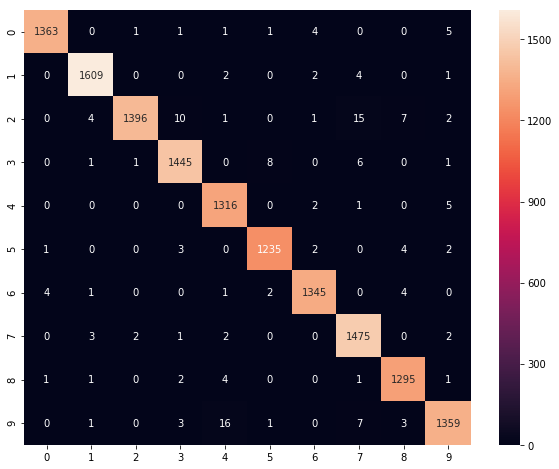

In [14]:
with chainer.using_config('train', False):
    
    preds = F.argmax(F.softmax(model.predictor(valid_x), axis=1), axis=1).data.squeeze()
    
cm = metrics.confusion_matrix(preds, valid_y)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

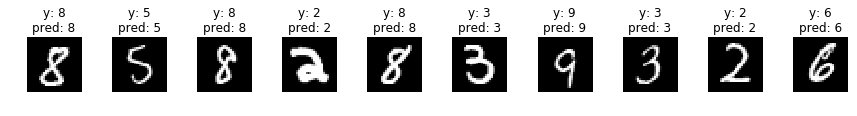

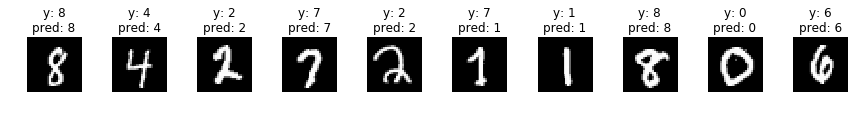

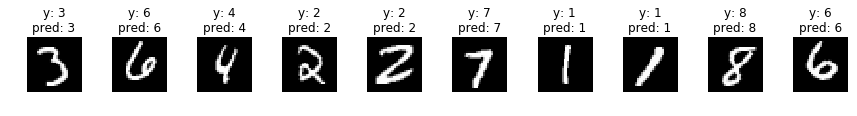

In [15]:
indices = np.random.choice(len(valid_x), 30)

for i, idx in enumerate(indices):
    
    if i%10 == 0:
        fig, axs = plt.subplots(ncols=10, figsize=(15,1))
    
    x = valid_x[idx]
    y = valid_y[idx]
    
    x_img = x.reshape(28, 28)
    x = x[np.newaxis]
    
    with chainer.using_config('train', False):
    
        pred = F.argmax(F.softmax(model.predictor(x), axis=1), axis=1).data.squeeze()
        
        axs[i%10].imshow(x_img, cmap='gray')
        title = 'y: {}'.format(y) + '\n' + 'pred: {}'.format(pred)
        axs[i%10].set_title(title)
        axs[i%10].axis('off')

plt.show()

In [16]:
!python --version

Python 3.6.3


In [17]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
prompt-toolkit==1.0.15
protobuf==3.5.2.post1
ptyprocess==0.5.2
pycurl=

In [1]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
